In [1]:
%%capture

import json
import speechbrain as sb
import os, sys
from speechbrain.utils.data_utils import get_all_files
import torch
from speechbrain.dataio.dataio import read_audio
import random
import torchaudio

import json
from tqdm import tqdm
import torchaudio
from joblib import Parallel, delayed

def process_file(path):
    # Optimized path operations
    parts = path.split("/")[-1].split("\\")[-1].split("_")
    id = "_".join(parts[:-1])
    num_speakers = parts[3]
    info = torchaudio.info(path)
    length = info.num_frames / 16000

    return id, {
        "wav_path": path.replace("\\","/"),
        "num_speakers": num_speakers,
        "length": length
    }

def load_json(json_paths, save_file="train"):
    data = {}

    # Parallel processing
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_file)(path) for path in json_paths
    )

    for id, path_data in results:
        data[id] = path_data

    with open(f"./maindata/{save_file}_data.json", 'w') as json_file:
        json.dump(data, json_file, indent=4)


# Example usage
train_files = get_all_files("./maindata/train", match_and=['_segment.wav'])
test_files = get_all_files("./maindata/dev", match_and=['_segment.wav'])
valid_files = get_all_files("./maindata/eval", match_and=['_segment.wav'])

load_json(train_files, save_file="train")
load_json(test_files, save_file="test")
load_json(valid_files, save_file="valid")


In [12]:
%%file hparams_selfsupervised.yaml

# Your code here
# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Dataset will be downloaded to the `data_original`
output_folder: !ref ./results/selfsupervised/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# URL for the ssl model, you can change to benchmark diffrenet models
# Important: we use wav2vec2 base and not the fine-tuned one with ASR task
# This allow you to have ~4% improvment
sslmodel_hub: facebook/wav2vec2-base
sslmodel_folder: !ref <save_folder>/ssl_checkpoint

# Path where data manifest files will be stored
data_folder: ./maindata  # e.g., /path/to/IEMOCAP_full_release
train_annotation: !ref <data_folder>/train_data.json
valid_annotation: !ref <data_folder>/valid_data.json
test_annotation: !ref <data_folder>/test_data.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


####################### Training Parameters ####################################
number_of_epochs: 15
batch_size: 64
lr: 0.001
lr_final: 0.0001
lr_ssl: 0.00001

#freeze all ssl
freeze_ssl: False
#set to true to freeze the CONV part of the ssl model
# We see an improvement of 2% with freezing CNNs
freeze_ssl_conv: True

####################### Model Parameters #######################################
encoder_dim: 768
emb_dim: 128
out_n_neurons: 5

dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 0  # 2 on linux but 0 works on windows
    drop_last: False

# ssl encoder
ssl_model: !new:speechbrain.lobes.models.huggingface_transformers.wav2vec2.Wav2Vec2
    source: !ref <sslmodel_hub>
    output_norm: True
    freeze: !ref <freeze_ssl>
    freeze_feature_extractor: !ref <freeze_ssl_conv>
    save_path: !ref <sslmodel_folder>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

tdnn_channels: 64
tdnn_channels_out: 128

embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <encoder_dim>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 3
    tdnn_channels:
        - !ref <tdnn_channels>
        - !ref <tdnn_channels>
        - !ref <tdnn_channels_out>
    tdnn_kernel_sizes: [5, 3, 1]
    tdnn_dilations: [1, 2, 1]
    lin_neurons: !ref <emb_dim>

classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <out_n_neurons>

# output_mlp: !new:speechbrain.nnet.linear.Linear
#     input_size: !ref <encoder_dim>
#     n_neurons: !ref <out_n_neurons>
#     bias: False

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    ssl_model: !ref <ssl_model>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model:  !ref <embedding_model>
    classifier: !ref <classifier>

model: !new:torch.nn.ModuleList
    - [!ref <embedding_model>, !ref <classifier>]

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

compute_cost: !name:speechbrain.nnet.losses.nll_loss

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

ssl_opt_class: !name:torch.optim.Adam
    lr: !ref <lr_ssl>

lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

lr_annealing_ssl: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr_ssl>
    improvement_threshold: 0.0025
    annealing_factor: 0.9

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        ssl_model: !ref <ssl_model>
        lr_annealing_output: !ref <lr_annealing>
        lr_annealing_ssl: !ref <lr_annealing_ssl>
        counter: !ref <epoch_counter>

Overwriting hparams_selfsupervised.yaml


In [5]:
%%file train_selfsupervised.py

# Your code here
#!/usr/bin/env python3
import os
import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml


class SelfSupervisedSpeakerCounter(sb.Brain):
    def compute_forward(self, batch, stage):
        """Computation pipeline based on a encoder + emotion classifier.
        """
        batch = batch.to(self.device)
        wavs, lens = batch.sig

        outputs = self.modules.ssl_model(wavs, lens)

        # last dim will be used for AdaptativeAVG pool
        outputs = self.hparams.avg_pool(outputs, lens)
        outputs = outputs.view(outputs.shape[0], -1)

        feats = self.modules.mean_var_norm(outputs, lens)
        embeddings = self.modules.embedding_model(feats, lens)
        outputs = self.modules.classifier(embeddings)
        
        # outputs = self.modules.output_mlp(outputs)
        # outputs = self.hparams.log_softmax(outputs)
        return outputs

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss using speaker-id as label.
        """
        spkid, _ = batch.num_speakers_encoded

        """to meet the input form of nll loss"""
        spkid = spkid.squeeze(1)
        loss = self.hparams.compute_cost(predictions, spkid)
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, spkid)

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error_rate": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            (
                old_lr_ssl,
                new_lr_ssl,
            ) = self.hparams.lr_annealing_ssl(stats["error_rate"])
            sb.nnet.schedulers.update_learning_rate(
                self.ssl_optimizer, new_lr_ssl
            )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr, "ssl_lr": old_lr_ssl},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(
                meta=stats, min_keys=["error_rate"]
            )

        # We also write statistics about test data to stdout and to logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )

    def init_optimizers(self):
        "Initializes the ssl optimizer and model optimizer"
        self.ssl_optimizer = self.hparams.ssl_opt_class(
            self.modules.ssl_model.parameters()
        )
        self.optimizer = self.hparams.opt_class(self.hparams.model.parameters())

        if self.checkpointer is not None:
            self.checkpointer.add_recoverable(
                "ssl_opt", self.ssl_optimizer
            )
            self.checkpointer.add_recoverable("optimizer", self.optimizer)

        self.optimizers_dict = {
            "model_optimizer": self.optimizer,
            "ssl_optimizer": self.ssl_optimizer,
        }


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined
    functions. We expect `prepare_mini_librispeech` to have been called before
    this, so that the `train.json`, `valid.json`,  and `valid.json` manifest
    files are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("wav_path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav_path):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav_path)
        return sig

    # Initialization of the label encoder. The label encoder assignes to each
    # of the observed label a unique index (e.g, 'spk01': 0, 'spk02': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("num_speakers")
    @sb.utils.data_pipeline.provides("num_speakers", "num_speakers_encoded")
    def label_pipeline(num_speakers):
        yield num_speakers
        num_speakers_encoded = label_encoder.encode_label_torch(num_speakers)
        yield num_speakers_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "num_speakers_encoded"],
        )
    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mappinng.

    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="num_speakers",
    )

    return datasets


# RECIPE BEGINS!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training).
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)

    hparams["ssl_model"] = hparams["ssl_model"].to(device=run_opts["device"])
    # freeze the feature extractor part when unfreezing
    if not hparams["freeze_ssl"] and hparams["freeze_ssl_conv"]:
        hparams["ssl_model"].model.feature_extractor._freeze_parameters()

    # Initialize the Brain object to prepare for mask training.
    emo_id_brain = SelfSupervisedSpeakerCounter(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    emo_id_brain.fit(
        epoch_counter=emo_id_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = emo_id_brain.evaluate(
        test_set=datasets["test"],
        min_key="error_rate",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Overwriting train_selfsupervised.py


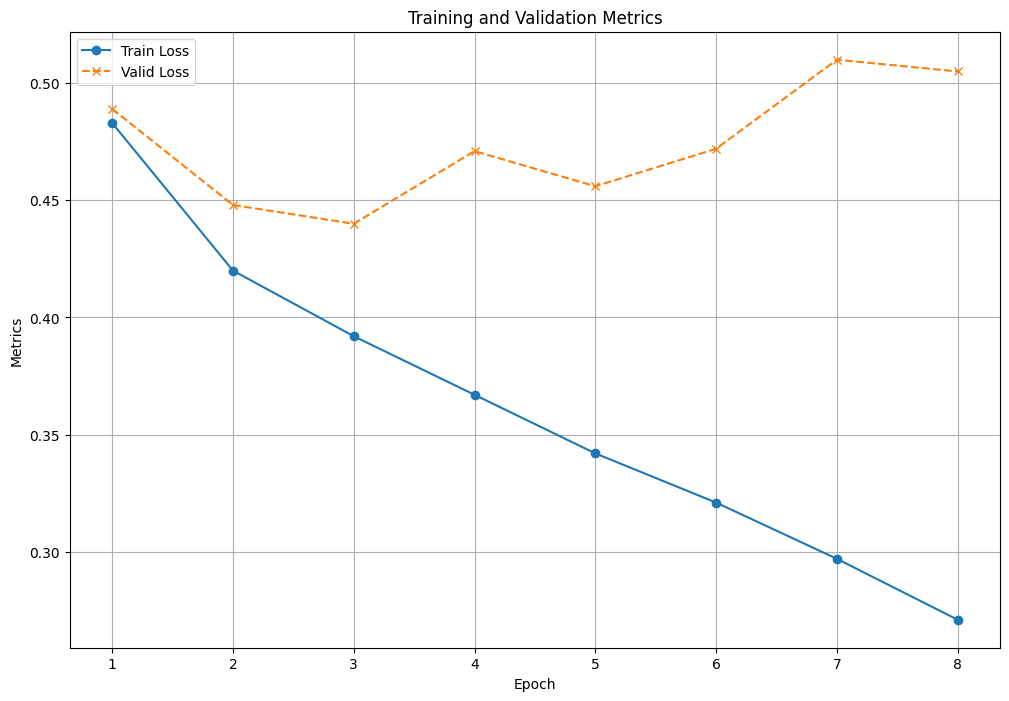

In [13]:
import matplotlib.pyplot as plt
import re

log_file_path = './results/selfsupervised/1986/train_log.txt'
# log_file_path = './results_backup_reduceonplateau/TIMIT_tiny/Xvector/FBanks/1986/train_log.txt'

epochs = []
train_losses = []
valid_losses = []
valid_errors = []
learning_rates = []
ssl_learning_rates = []  # Adding a list for ssl learning rates

# Updated pattern to match the new log format
pattern = re.compile(
    r'Epoch: (\d+), lr: (\d\.\d+e-\d{2}|\d+\.\d+), ssl_lr: (\d\.\d+e-\d{2}|\d+\.\d+) - train loss: (\d+\.\d+e-\d{2}|\d+\.\d+) - valid loss: (\d+\.\d+e-\d{2}|\d+\.\d+), valid error_rate: (\d\.\d+e-\d{2}|\d+\.\d+)'
)

with open(log_file_path, 'r') as file:
    for line in file:
        match = pattern.match(line)
        if match:
            epoch, lr, ssl_lr, train_loss, valid_loss, valid_error = match.groups()
            epochs.append(int(epoch))
            learning_rates.append(float(lr))
            ssl_learning_rates.append(float(ssl_lr))  # Adding the ssl_lr to its list
            train_losses.append(float(train_loss))
            valid_losses.append(float(valid_loss))
            valid_errors.append(float(valid_error))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='x', linestyle='--')
# plt.plot(epochs, valid_errors, label='Valid Error Rate', marker='^', linestyle='-.')  # Plotting valid error rates as well

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()